# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se 
- o cálculo do gradiente automático do PyTorch, porém 
- a função de perda e 
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

<img src='../figures/RegressaoLinear_Otimizacao.png' width="500"></a>

## Importação dos pacotes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim

torch.manual_seed(1234)

## Leitura dos dados

In [2]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [3]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [4]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [5]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)

## Model

<img src='../figures/RegressaoLinearNeuronio.png' width="400"></a>

In [6]:
model = torch.nn.Linear(2, 1, bias=False)

### Verificando a inicialização dos parâmetros

In [7]:
#model.weight.data = torch.zeros(1,2)
#torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight.data

tensor([[-0.6661, -0.1387]])

### Testando o predict da rede

In [8]:
model(torch.ones((5,2)))

tensor([[-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049],
        [-0.8049]], grad_fn=<MmBackward>)

## Treinamento

In [9]:
num_epochs = 10
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = x_train_bias
    target = y_train

    # forward - predict
    out = model(inputs)

    #loss cálculo da função de perda
    loss = torch.pow(out - target, 2).mean()
    print('loss:',loss.data.numpy())
    
    # backward propagation - cálculo gradiente
    loss.backward()
    
    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data
    
    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data[0]))

loss: 1.8425571
loss: 0.1437296
loss: 0.032552265
loss: 0.024986992
loss: 0.024210226
loss: 0.023902435
loss: 0.023648918
loss: 0.023420446
loss: 0.023213122
loss: 0.023024905


## Avaliação

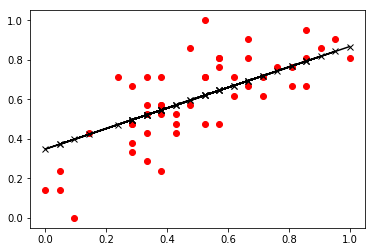

In [10]:
y_pred = model(x_train_bias)
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [11]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.3482, 0.5186]]))])

### Parâmetros ótimos, solução analítica

In [12]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data[0]`? Por que precisa do `data` e por que precisa da indexação por zero?
   

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação 
   dos parâmetros do modelo duas dimensões. 
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

## Ploting vectors

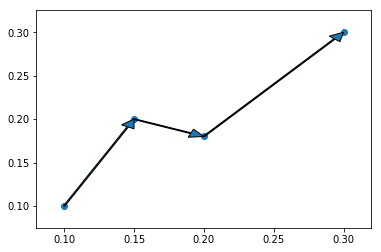

In [13]:
# Exemplo
w0_list = [0.1, 0.15, 0.2, 0.3]
w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1


# Aprendizados